## Análisis del conjunto Adult Income (Census Income)

Este cuaderno presenta un análisis reproducible del dataset Adult Income (Census Income). El objetivo es desarrollar modelos de clasificación para predecir si una persona percibe más de 50K USD anuales.

Objetivos:
- Construir pipelines reproducibles y evitar fuga de información.
- Evaluar el rendimiento mediante métricas robustas (AUC, F1, Brier score) y curvas relevantes.
- Analizar la calibración de probabilidades y la equidad entre subgrupos (género, raza).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (silhouette_score, pairwise_distances, calinski_harabasz_score,
                             accuracy_score, confusion_matrix, classification_report, 
                            roc_auc_score,precision_recall_curve, brier_score_loss, 
                            f1_score, recall_score, precision_score, roc_curve)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

from scipy.stats import zscore
from scipy import stats

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import lightgbm as lgb
import missingno as msno

from category_encoders import TargetEncoder, CountEncoder

import warnings
warnings.filterwarnings('ignore')
                             


## 1. Librerías y configuración

A continuación se importan las dependencias necesarias para el análisis, la visualización y el modelado. Se procura mantener el entorno reproducible y documentado.

In [3]:
path = Path().resolve()
income_df = pd.read_csv(path / 'adult.csv')

print(f'El conjunto de datos contiene {income_df.shape[0]} filas y {income_df.shape[1]} columnas.')
print('\nPrimeras 5 filas del conjunto de datos:')
display(income_df.head())

El conjunto de datos contiene 32561 filas y 15 columnas.

Primeras 5 filas del conjunto de datos:


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


## 2. Carga de datos

Se cargan los datos desde el archivo local y se realiza una inspección inicial de filas, columnas y muestras representativas.


Valores nulos por columna:


workclass         1836
occupation        1843
native.country     583
dtype: int64


Tipos de datos por columna:


age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object


Visualización de valores faltantes: 


<Axes: >

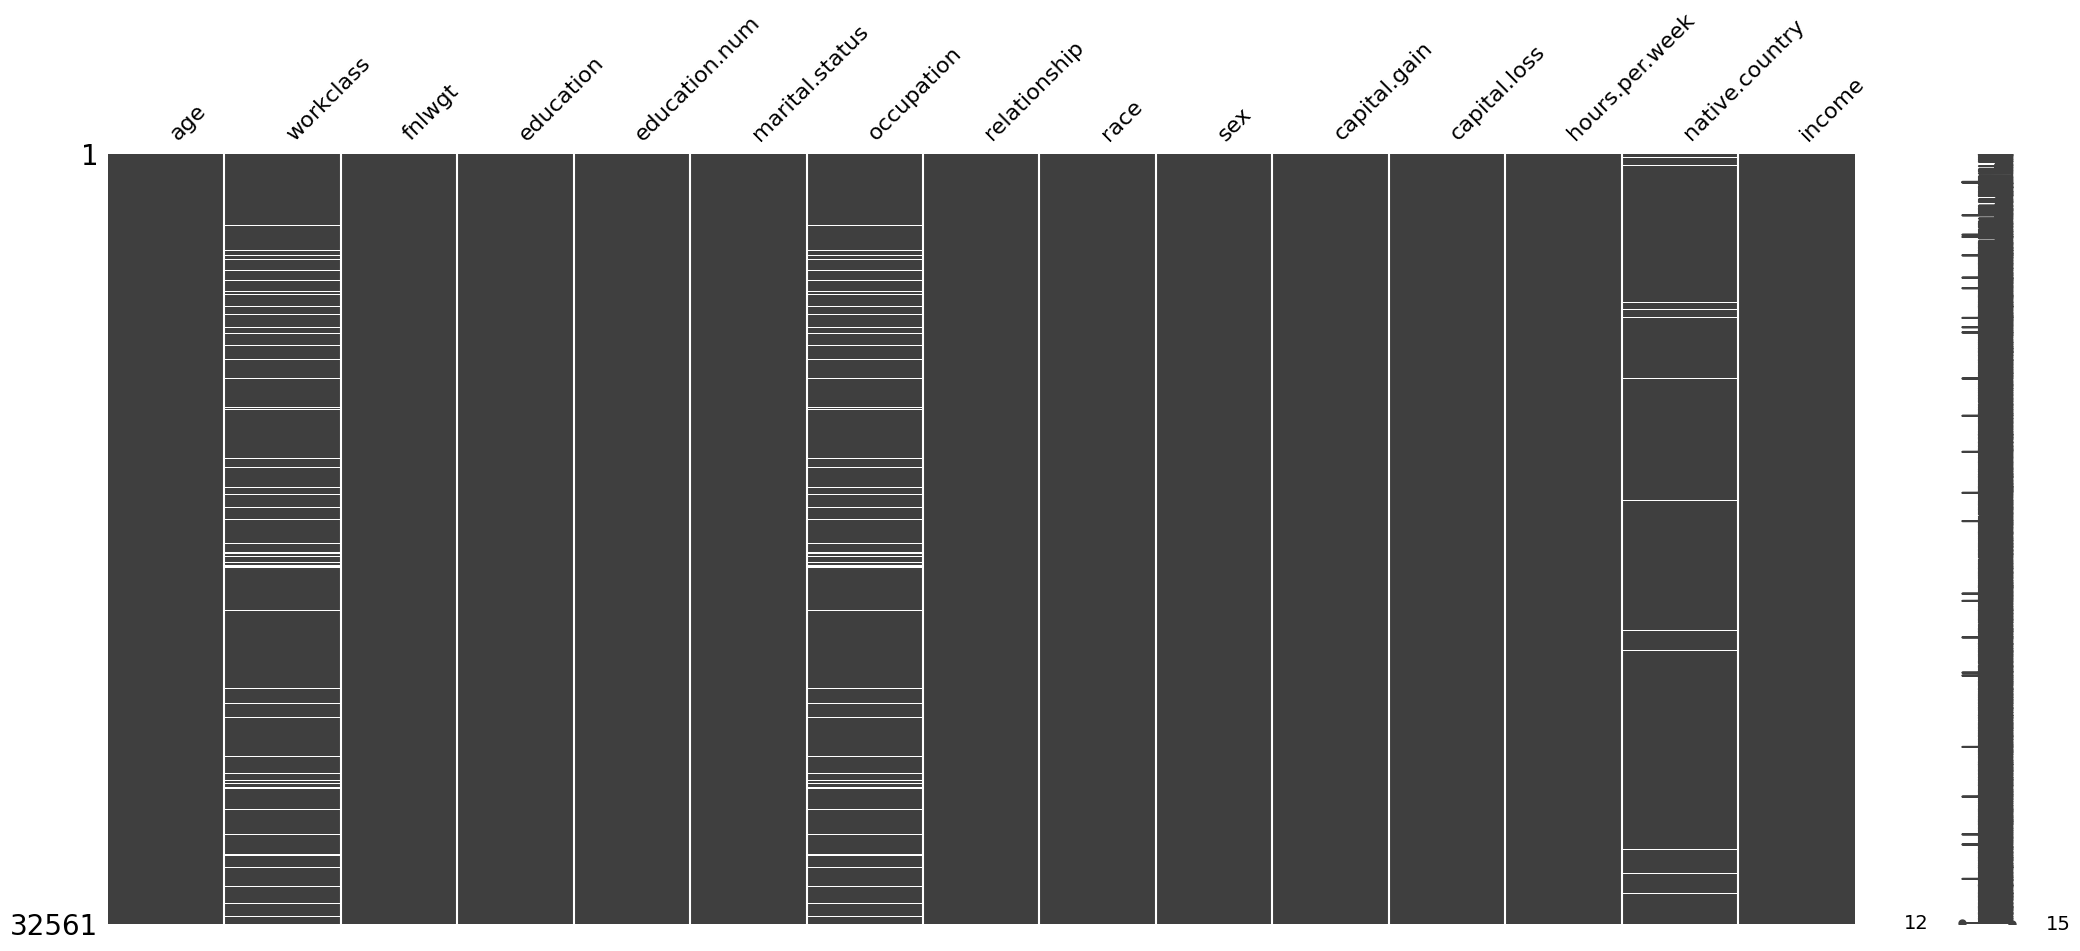

In [4]:
# Vemos valores nulos
print('\nValores nulos por columna:')
income_df.replace('?', np.nan, inplace=True) # Reemplazamos '?' por NaN para detectar valores faltantes
nulos = income_df.isnull().sum()
display(nulos[nulos > 0])

# Vemos tipos de datos
print('\nTipos de datos por columna:')
display(income_df.dtypes)

# Usamos missingno para ver valores faltantes
print('\nVisualización de valores faltantes: ')
msno.matrix(income_df)

## 3. Exploración de datos (EDA)

### 3.1 Valores faltantes

Se identifican los valores faltantes y se normalizan las marcas de ausencia para tratarlos de forma consistente durante el preprocesamiento.

In [5]:
# Estadísticas descriptivas
print('\nEstadísticas descriptivas del conjunto de datos:')
display(income_df.describe(include='all'))


Estadísticas descriptivas del conjunto de datos:


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
count,32561.000000,30725,3.256100e+04,32561,32561.000000,32561,30718,32561,32561,32561,32561.000000,32561.000000,32561.000000,31978,32561
unique,NaN,8,NaN,16,NaN,7,14,6,5,2,NaN,NaN,NaN,41,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,22696,NaN,10501,NaN,14976,4140,13193,27816,21790,NaN,NaN,NaN,29170,24720
mean,38.581647,NaN,1.897784e+05,NaN,10.080679,NaN,NaN,NaN,NaN,NaN,1077.648844,87.303830,40.437456,NaN,NaN
std,13.640433,NaN,1.055500e+05,NaN,2.572720,NaN,NaN,NaN,NaN,NaN,7385.292085,402.960219,12.347429,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.178270e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.783560e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.370510e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN



=== Balance de clases ===


income
<=50K    24720
>50K      7841
Name: count, dtype: int64


Proporción de personas con >50K: 24.08%


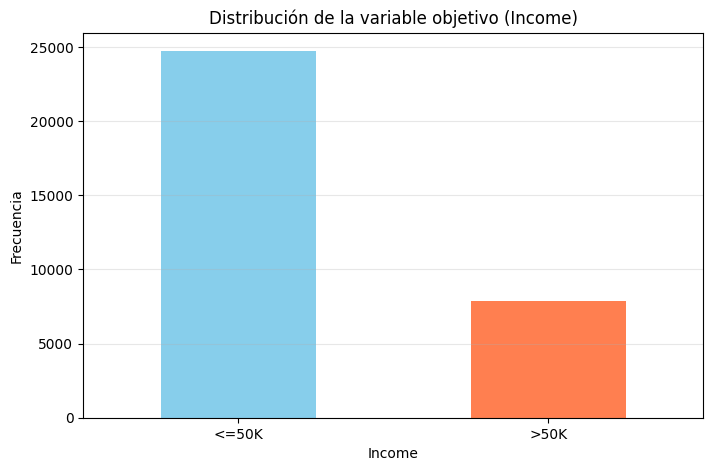

In [6]:
# Balance de clases en la variable objetivo
print('\n=== Balance de clases ===')
class_counts = income_df['income'].value_counts()
display(class_counts)
print(f'\nProporción de personas con >50K: {class_counts.get(">50K", class_counts.get(" >50K", 0)) / len(income_df) * 100:.2f}%')

# Visualización del balance
plt.figure(figsize=(8, 5))
income_df['income'].value_counts().plot(kind='bar', color=['skyblue', 'coral'])
plt.title('Distribución de la variable objetivo (Income)')
plt.xlabel('Income')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

### 3.2 Balance de clases

Antes de entrenar, se verifica la distribución de la variable objetivo. En presencia de clases minoritarias, se priorizarán métricas como AUC, recall y la curva precision–recall.

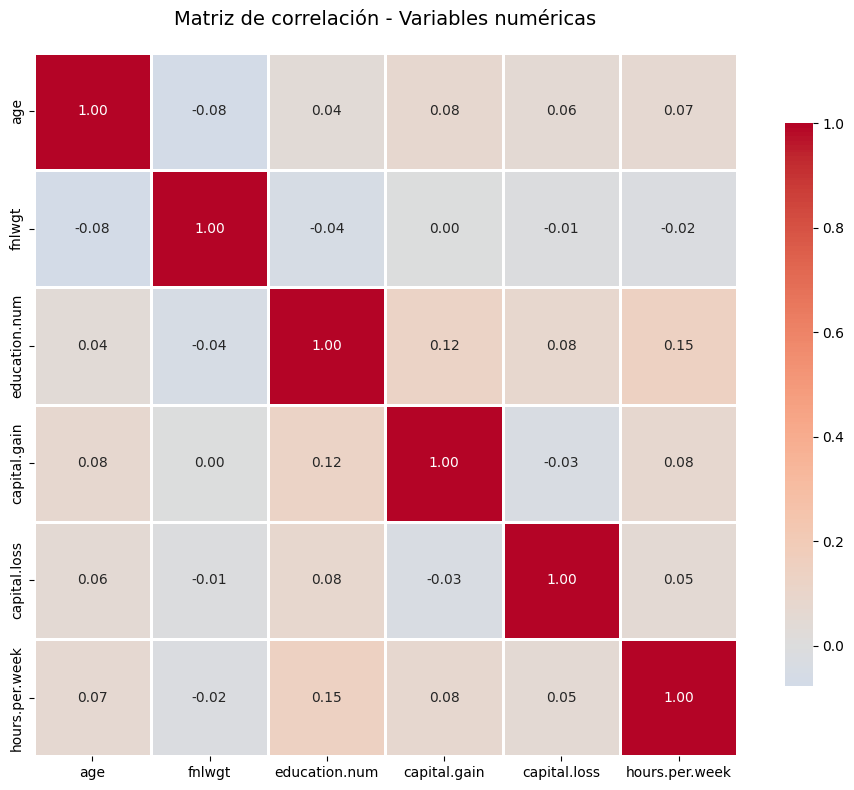


Correlaciones más fuertes (|r| > 0.3):
No hay correlaciones fuertes entre las variables numéricas.


In [7]:
# Correlaciones entre variables numéricas
numeric_cols = income_df.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 0:
    plt.figure(figsize=(10, 8))
    corr_matrix = income_df[numeric_cols].corr()
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Matriz de correlación - Variables numéricas', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()
    
    # Mostramos las correlaciones más fuertes (en valor absoluto)
    print('\nCorrelaciones más fuertes (|r| > 0.3):')
    corr_pairs = corr_matrix.unstack()
    corr_pairs = corr_pairs[corr_pairs != 1.0]  # removemos diagonal
    strong_corr = corr_pairs[abs(corr_pairs) > 0.3].sort_values(ascending=False)
    if len(strong_corr) > 0:
        display(strong_corr.head(10))
    else:
        print('No hay correlaciones fuertes entre las variables numéricas.')

### 3.3 Correlaciones (variables numéricas)

Se examinan las correlaciones entre variables numéricas para detectar redundancias o señales fuertes que orienten la ingeniería de variables. Correlación no implica causalidad; sirve como guía exploratoria.


Variables numéricas: ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']


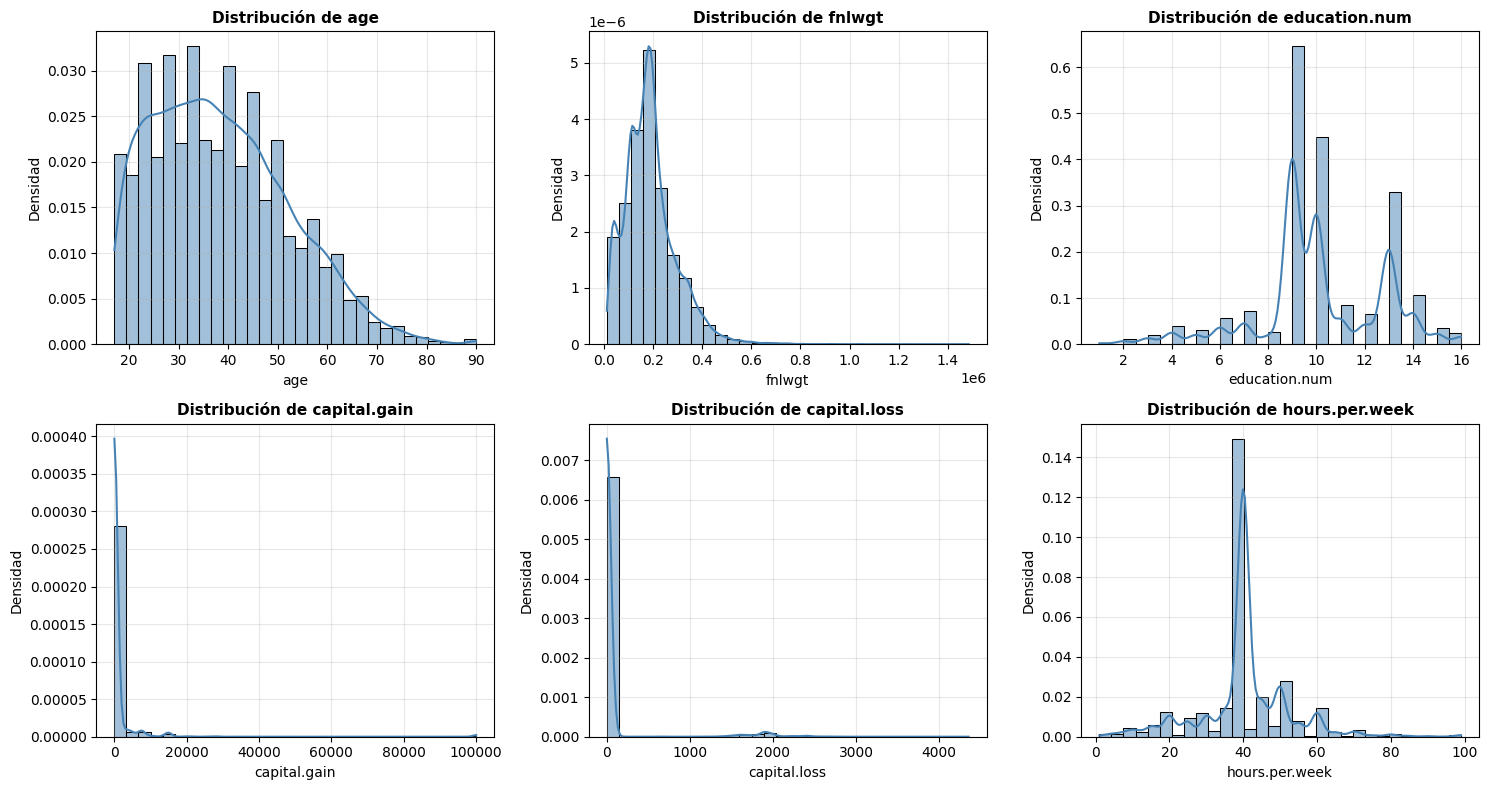

In [8]:
# Distribuciones de variables numéricas (solo las importantes)
numeric_cols_only = income_df.select_dtypes(include=[np.number]).columns.tolist()
print(f'\nVariables numéricas: {numeric_cols_only}')

if len(numeric_cols_only) > 0:
    n_cols = len(numeric_cols_only)
    n_rows = (n_cols + 2) // 3  # 3 columnas por fila
    
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, n_rows * 4))
    axes = axes.flatten() if n_cols > 1 else [axes]
    
    for idx, col in enumerate(numeric_cols_only):
        sns.histplot(income_df[col].dropna(), kde=True, bins=30, color='steelblue', 
                     stat='density', ax=axes[idx])
        axes[idx].set_title(f'Distribución de {col}', fontsize=11, weight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Densidad')
        axes[idx].grid(alpha=0.3)
    
    # Ocultar subplots vacíos
    for idx in range(n_cols, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print('No hay variables numéricas para graficar.')

### 3.4 Distribuciones y valores atípicos

Se analizan las distribuciones y posibles valores atípicos para definir estrategias apropiadas de imputación y transformación.

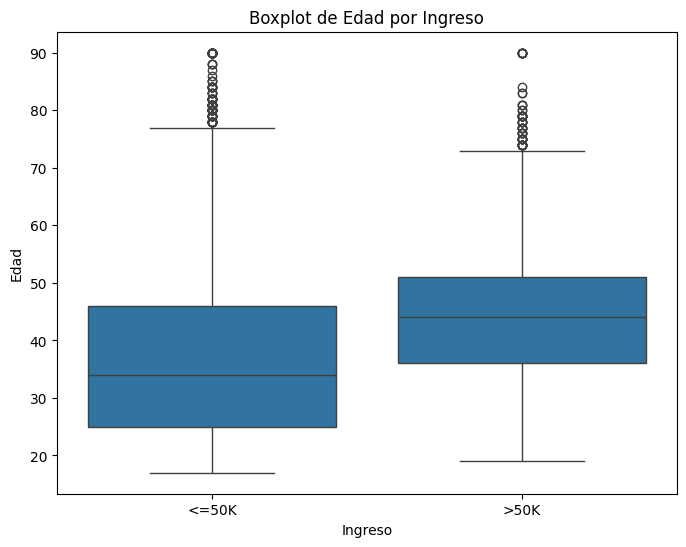

In [9]:
# Buscamos Boxplots para detectar outliers en variable objetivo 'income'
plt.figure(figsize=(8, 6))
sns.boxplot(x='income', y='age', data=income_df)
plt.title('Boxplot de Edad por Ingreso')
plt.xlabel('Ingreso')
plt.ylabel('Edad')
plt.show()

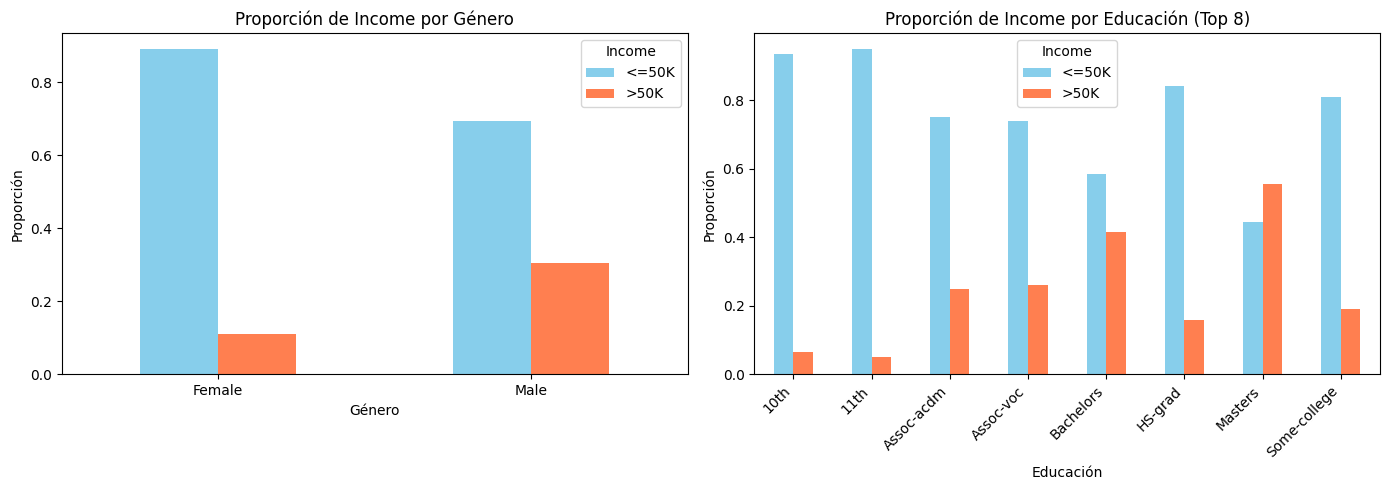

In [10]:
# Análisis por género y educación
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Income por género
if 'sex' in income_df.columns:
    pd.crosstab(income_df['sex'], income_df['income'], normalize='index').plot(
        kind='bar', ax=axes[0], color=['skyblue', 'coral']
    )
    axes[0].set_title('Proporción de Income por Género')
    axes[0].set_xlabel('Género')
    axes[0].set_ylabel('Proporción')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
    axes[0].legend(title='Income')

# Income por educación (top 8 categorías)
if 'education' in income_df.columns:
    top_edu = income_df['education'].value_counts().head(8).index
    df_edu = income_df[income_df['education'].isin(top_edu)]
    pd.crosstab(df_edu['education'], df_edu['income'], normalize='index').plot(
        kind='bar', ax=axes[1], color=['skyblue', 'coral']
    )
    axes[1].set_title('Proporción de Income por Educación (Top 8)')
    axes[1].set_xlabel('Educación')
    axes[1].set_ylabel('Proporción')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
    axes[1].legend(title='Income')

plt.tight_layout()
plt.show()

## 4. Preprocesamiento y modelado

En esta sección se define el pipeline de preprocesamiento y se describen las decisiones metodológicas adoptadas para asegurar comparaciones justas entre modelos y minimizar fugas de información.

Resumen de decisiones:
- Numéricas: imputación basada en vecinos o imputadores iterativos y escalado.
- Categóricas: imputación por moda y codificación basada en frecuencia.

Posteriormente se entrenarán modelos y se evaluará su rendimiento y calibración.

### 4.1 Relación con la variable objetivo y variables sensibles

Antes de modelar, se examina la relación entre características relevantes (por ejemplo, educación y género) y la variable objetivo, a fin de identificar señales predictivas y posibles sesgos.

Features numéricas (6): ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
Features categóricas (8): ['workclass', 'education', 'marital.status', 'occupation', 'relationship']...

Distribución del target: {0: 24720, 1: 7841}
Proporción clase positiva: 24.08%

Train: (22792, 14), Test: (9769, 14)

Fiteando preprocessor...
Datos preprocesados: (22792, 14)

Entrenando RandomForest con calibración...

=== RESULTADOS - RandomForest Calibrado ===
Accuracy: 0.8584
AUC: 0.9086
Brier score: 0.1016

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.88      0.94      0.91      7417
        >50K       0.76      0.61      0.67      2352

    accuracy                           0.86      9769
   macro avg       0.82      0.77      0.79      9769
weighted avg       0.85      0.86      0.85      9769


Mejor threshold por F1: 0.3059

Con threshold optimizado:
              precision    recall  f1-score   support

       

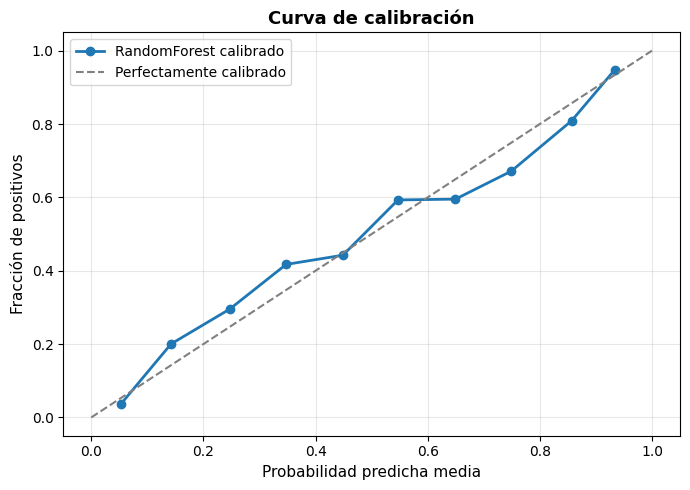



Entrenando LightGBM (scale_pos_weight=3.15)...

=== RESULTADOS - LightGBM (sin calibrar) ===
Accuracy: 0.8405
AUC: 0.9167
Brier score: 0.1087

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.93      0.85      0.89      7417
        >50K       0.63      0.80      0.71      2352

    accuracy                           0.84      9769
   macro avg       0.78      0.83      0.80      9769
weighted avg       0.86      0.84      0.85      9769



In [ ]:
# ============================================================================
# PREPROCESAMIENTO
# ============================================================================

# Definimos features numéricas y categóricas (excluyendo 'income' que es el target)
numeric_features = income_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in income_df.columns if income_df[c].dtype == 'object' and c != 'income']

print(f'Features numéricas ({len(numeric_features)}): {numeric_features}')
print(f'Features categóricas ({len(categorical_features)}): {categorical_features[:5]}...')  # primeras 5

# Pipeline para numéricas: KNNImputer + escalado
# KNN es mejor que la media porque usa info de vecinos similares
num_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('freq_enc', CountEncoder()),  # Alternativa: OrdinalEncoder, OneHotEncoder
])

# ColumnTransformer: aplica cada pipeline a su tipo de features
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_features),
    ('cat', cat_pipeline, categorical_features)
])

# Definimos X e y
X = income_df.drop(columns=['income']).copy()
y = (income_df['income'].str.strip() == '>50K').astype(int)  # Binaria: 1 si >50K, 0 si <=50K

print(f'\nDistribución del target: {y.value_counts().to_dict()}')
print(f'Proporción clase positiva: {y.mean():.2%}')

# Split estratificado (mantiene proporción de clases)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

print(f'\nTrain: {X_train.shape}, Test: {X_test.shape}')

# IMPORTANTE: Fiteamos el preprocessor primero para poder reutilizarlo
# Esto evita tener que fitear múltiples veces
print('\nFiteando preprocessor...')
preprocessor.fit(X_train, y_train)

# Transformamos los datos (guardamos para reutilizar con LightGBM y SMOTE)
X_train_prep = preprocessor.transform(X_train)
X_test_prep = preprocessor.transform(X_test)

print(f'Datos preprocesados: {X_train_prep.shape}')

# ============================================================================
# MODELO BASELINE: RandomForest con class_weight balanced
# ============================================================================

# Pipeline completo: preprocessor + clasificador
clf = Pipeline([
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=500, 
        random_state=42, 
        n_jobs=-1, 
        class_weight='balanced'  # Para manejar desbalance de clases
    ))
])

# Calibración de probabilidades con CV interno
# Sigmoid es más rápido, isotonic más flexible (pero puede overfittear)
print('\nEntrenando RandomForest con calibración...')
calib = CalibratedClassifierCV(estimator=clf, cv=3, method='sigmoid')
calib.fit(X_train, y_train)

# Predicciones
y_proba_cal = calib.predict_proba(X_test)[:, 1]  # Probabilidades
y_pred_cal = calib.predict(X_test)  # Etiquetas binarias

# Métricas
print('\n=== RESULTADOS - RandomForest Calibrado ===')
print(f'Accuracy: {accuracy_score(y_test, y_pred_cal):.4f}')
print(f'AUC: {roc_auc_score(y_test, y_proba_cal):.4f}')
print(f'Brier score: {brier_score_loss(y_test, y_proba_cal):.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred_cal, target_names=['<=50K', '>50K']))

# Mejor umbral por F1
prec, rec, th = precision_recall_curve(y_test, y_proba_cal)
f1_scores = 2 * prec * rec / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1_scores)
best_thresh = th[best_idx] if best_idx < len(th) else 0.5
print(f'\nMejor threshold por F1: {best_thresh:.4f}')

# Predicciones con threshold optimizado
y_pred_thresh = (y_proba_cal >= best_thresh).astype(int)
print('\nCon threshold optimizado:')
print(classification_report(y_test, y_pred_thresh, target_names=['<=50K', '>50K']))

# Curva de calibración
prob_true, prob_pred = calibration_curve(y_test, y_proba_cal, n_bins=10)
plt.figure(figsize=(7, 5))
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='RandomForest calibrado')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfectamente calibrado')
plt.xlabel('Probabilidad predicha media', fontsize=11)
plt.ylabel('Fracción de positivos', fontsize=11)
plt.title('Curva de calibración', fontsize=13, weight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# MODELO 2: LightGBM (sin calibrar)
# ============================================================================


# Calculamos el ratio de clases para scale_pos_weight
ratio = (y_train == 0).sum() / (y_train == 1).sum()
print(f'\n\nEntrenando LightGBM (scale_pos_weight={ratio:.2f})...')

model_lgb = lgb.LGBMClassifier(
    scale_pos_weight=ratio,  # Ajuste por desbalance
    n_estimators=500,
    random_state=42,
    verbosity=-1  # Silenciar warnings
)

# LightGBM necesita datos numéricos, usamos el preprocessor ya fitted
# Reutilizamos X_train_prep y X_test_prep que creamos arriba
model_lgb.fit(X_train_prep, y_train)

# Predicciones
y_proba_lgb = model_lgb.predict_proba(X_test_prep)[:, 1]
y_pred_lgb = model_lgb.predict(X_test_prep)

# Métricas
print('\n=== RESULTADOS - LightGBM (sin calibrar) ===')
print(f'Accuracy: {accuracy_score(y_test, y_pred_lgb):.4f}')
print(f'AUC: {roc_auc_score(y_test, y_proba_lgb):.4f}')
print(f'Brier score: {brier_score_loss(y_test, y_proba_lgb):.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred_lgb, target_names=['<=50K', '>50K']))

### 4.2 SMOTE (sobremuestreo)

SMOTE genera ejemplos sintéticos de la clase minoritaria. Se aplica exclusivamente al conjunto de entrenamiento para evitar contaminación del conjunto de evaluación.

In [12]:
# Preprocesar primero (SMOTE necesita arrays numéricos)
X_train_prep_smote = calib.estimator.named_steps['preproc'].transform(X_train)

# Aplicar SMOTE solo al training
print('Distribución ANTES de SMOTE:', dict(zip(*np.unique(y_train, return_counts=True))))
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_prep_smote, y_train)
print('Distribución DESPUÉS de SMOTE:', dict(zip(*np.unique(y_train_smote, return_counts=True))))

# Entrenar RF sobre datos con SMOTE
print('\nEntrenando RandomForest con SMOTE...')
rf_smote = RandomForestClassifier(
    n_estimators=500, 
    random_state=42, 
    n_jobs=-1
    # NO usamos class_weight aquí porque ya balanceamos con SMOTE
)
rf_smote.fit(X_train_smote, y_train_smote)

# Predicciones (test NO oversampled!)
y_pred_smote = rf_smote.predict(X_test_prep)
y_proba_smote = rf_smote.predict_proba(X_test_prep)[:, 1]

# Métricas
print('\n=== RESULTADOS - RandomForest con SMOTE ===')
print(f'Accuracy: {accuracy_score(y_test, y_pred_smote):.4f}')
print(f'AUC: {roc_auc_score(y_test, y_proba_smote):.4f}')
print(f'Brier score: {brier_score_loss(y_test, y_proba_smote):.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred_smote, target_names=['<=50K', '>50K']))

# Comparación rápida: SMOTE vs class_weight
comparison = pd.DataFrame({
    'Modelo': ['RF + class_weight', 'RF + SMOTE', 'LightGBM'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_cal),
        accuracy_score(y_test, y_pred_smote),
        accuracy_score(y_test, y_pred_lgb)
    ],
    'AUC': [
        roc_auc_score(y_test, y_proba_cal),
        roc_auc_score(y_test, y_proba_smote),
        roc_auc_score(y_test, y_proba_lgb)
    ],
    'Recall >50K': [
        recall_score(y_test, y_pred_cal),
        recall_score(y_test, y_pred_smote),
        recall_score(y_test, y_pred_lgb)
    ],
    'Precision >50K': [
        precision_score(y_test, y_pred_cal),
        precision_score(y_test, y_pred_smote),
        precision_score(y_test, y_pred_lgb)
    ]
})

print('\n=== Comparación de estrategias ===')
display(comparison.round(4))

Distribución ANTES de SMOTE: {np.int64(0): np.int64(17303), np.int64(1): np.int64(5489)}
Distribución DESPUÉS de SMOTE: {np.int64(0): np.int64(17303), np.int64(1): np.int64(17303)}

Entrenando RandomForest con SMOTE...

=== RESULTADOS - RandomForest con SMOTE ===
Accuracy: 0.8367
AUC: 0.8969
Brier score: 0.1130

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.91      0.87      0.89      7417
        >50K       0.64      0.72      0.68      2352

    accuracy                           0.84      9769
   macro avg       0.78      0.80      0.79      9769
weighted avg       0.84      0.84      0.84      9769


=== Comparación de estrategias ===


,Modelo,Accuracy,AUC,Recall >50K,Precision >50K
0,RF + class_weight,0.8584,0.9086,0.6063,0.7573
1,RF + SMOTE,0.8367,0.8969,0.7215,0.6435
2,LightGBM,0.8405,0.9167,0.8031,0.6330


### 4.3 Validación cruzada estratificada

Para obtener estimaciones más estables del rendimiento se emplea validación cruzada estratificada, reduciendo la varianza asociada a un único particionado.

In [13]:
from sklearn.model_selection import cross_validate, StratifiedKFold

# Definimos las métricas que queremos evaluar
scoring = {
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

# CV con 5 folds estratificados
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print('Ejecutando validación cruzada (esto puede tardar un rato)...\n')

# CV para RandomForest con class_weight
cv_results_rf = cross_validate(
    clf,  # El pipeline completo
    X_train, y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

# Resultados
print('=== Resultados CV - RandomForest con class_weight ===')
for metric in scoring.keys():
    scores = cv_results_rf[f'test_{metric}']
    print(f'{metric.capitalize():12} -> mean: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})')

# Opcional: probar LightGBM con CV (sin usar Pipeline, porque ya preprocesamos)
print('\n\nEjecutando CV para LightGBM...')
# Necesitamos preprocesar todo X_train primero
X_train_full_prep = calib.estimator.named_steps['preproc'].transform(X_train)

cv_results_lgb = cross_validate(
    model_lgb,
    X_train_full_prep, y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

print('\n=== Resultados CV - LightGBM ===')
for metric in scoring.keys():
    scores = cv_results_lgb[f'test_{metric}']
    print(f'{metric.capitalize():12} -> mean: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})')

Ejecutando validación cruzada (esto puede tardar un rato)...

=== Resultados CV - RandomForest con class_weight ===
Accuracy     -> mean: 0.8596 (+/- 0.0088)
Roc_auc      -> mean: 0.9084 (+/- 0.0109)
Precision    -> mean: 0.7550 (+/- 0.0212)
Recall       -> mean: 0.6178 (+/- 0.0332)
F1           -> mean: 0.6794 (+/- 0.0240)


Ejecutando CV para LightGBM...

=== Resultados CV - LightGBM ===
Accuracy     -> mean: 0.8450 (+/- 0.0066)
Roc_auc      -> mean: 0.9206 (+/- 0.0087)
Precision    -> mean: 0.6437 (+/- 0.0123)
Recall       -> mean: 0.7989 (+/- 0.0217)
F1           -> mean: 0.7129 (+/- 0.0124)


## 5. Comparación de modelos

Se comparan los modelos considerando métricas, curvas ROC/PR, calibración y matrices de confusión, con el propósito de comprender trade-offs y robustez.

,accuracy,auc,precision,recall,f1,brier
model,,,,,,
Calibrated RF,0.8584,0.9086,0.7573,0.6063,0.6734,0.1016
LightGBM,0.8405,0.9167,0.6330,0.8031,0.7080,0.1087


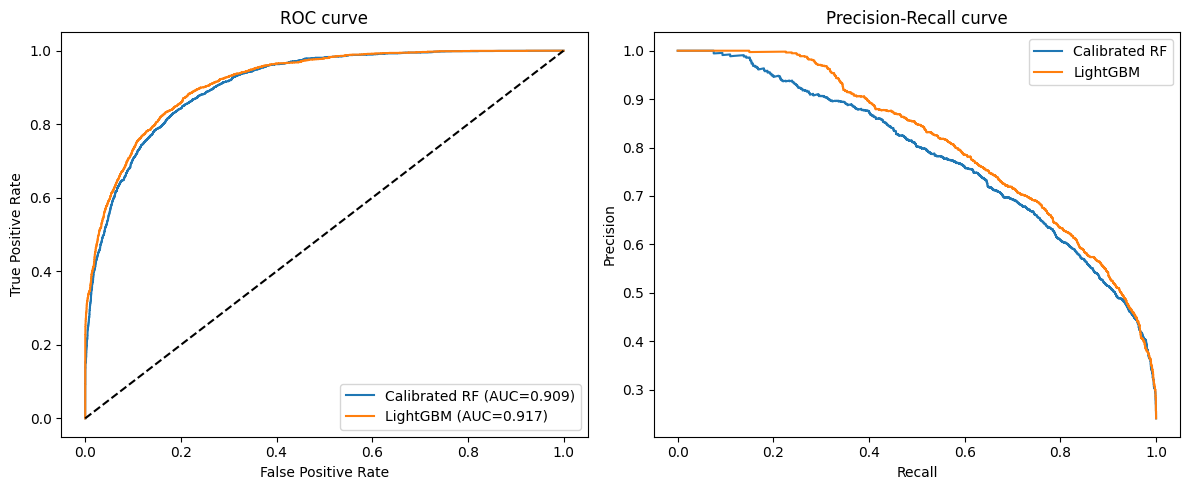

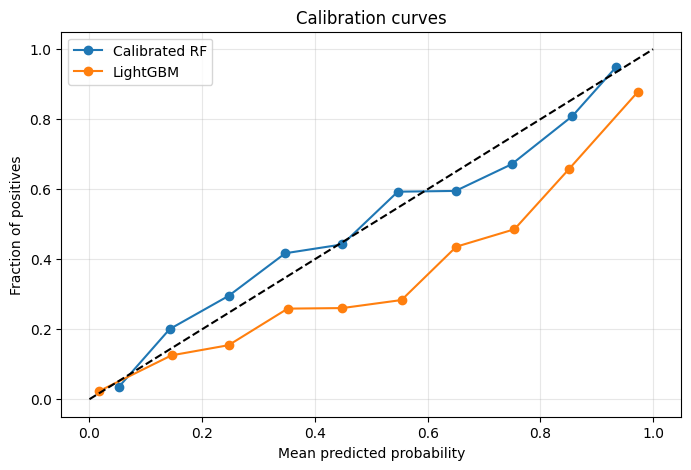


Confusion matrix - Calibrated RF
[[6960  457]
 [ 926 1426]]

Confusion matrix - LightGBM
[[6322 1095]
 [ 463 1889]]


In [14]:


# Preparar métricas para ambos modelos (suponiendo que las variables existen en el notebook)
results = []
models = [('Calibrated RF', y_pred_cal, y_proba_cal), ('LightGBM', y_pred_lgb, y_proba_lgb)]
for name, y_pred, y_proba in models:
    acc = accuracy_score(y_test, y_pred)
    aucs = roc_auc_score(y_test, y_proba)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    brier = brier_score_loss(y_test, y_proba)
    results.append({'model':name,'accuracy':acc,'auc':aucs,'precision':prec,'recall':rec,'f1':f1,'brier':brier})

metrics_df = pd.DataFrame(results).set_index('model')
display(metrics_df.round(4))

# Plot ROC y Precision-Recall juntos
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for name, y_pred, y_proba in models:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc_score(y_test,y_proba):.3f})')
plt.plot([0,1],[0,1],'--',color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()

plt.subplot(1,2,2)
for name, y_pred, y_proba in models:
    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(rec, prec, label=f'{name}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.tight_layout()
plt.show()

# Curvas de calibración comparadas
plt.figure(figsize=(8,5))
for name, y_pred, y_proba in models:
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=name)
plt.plot([0,1],[0,1],'--',color='k')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curves')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Matrices de confusión detalladas
for name, y_pred, y_proba in models:
    print('\nConfusion matrix -', name)
    print(confusion_matrix(y_test, y_pred))


## 6. Importancia de variables

Se presentan las variables más relevantes según cada modelo. La interpretación debe realizarse con cautela: importancia no implica causalidad.

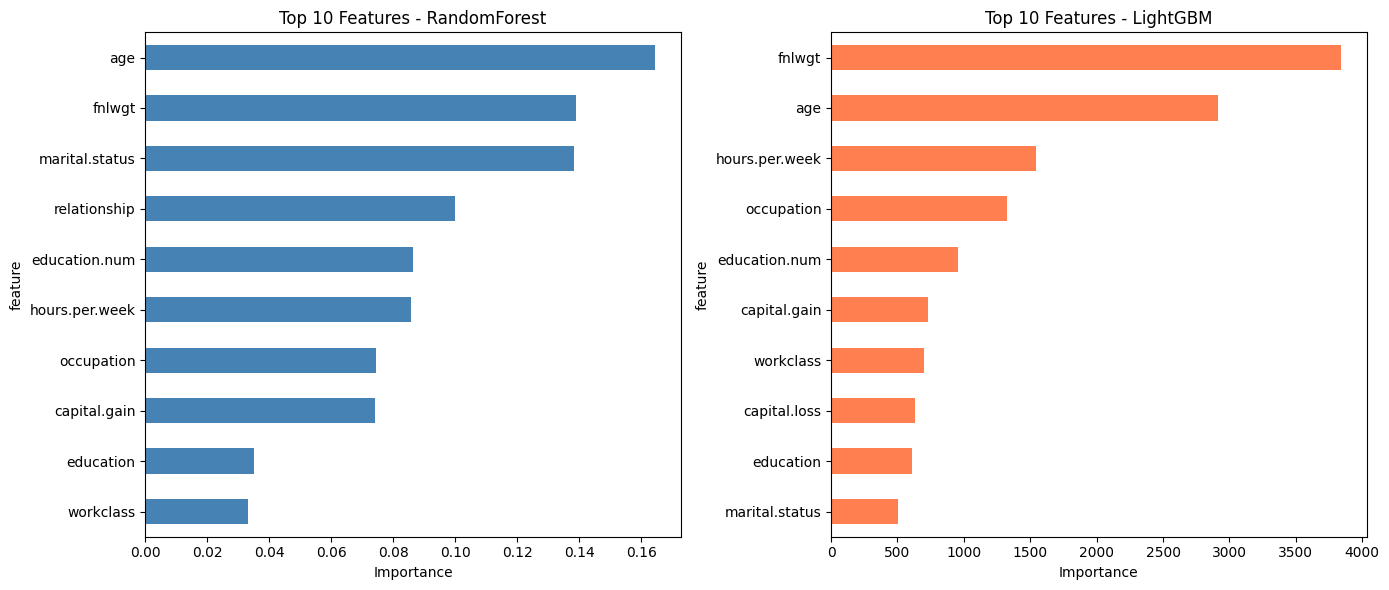


Top 5 features por modelo:

RandomForest:


,feature,importance
0,age,0.164532
1,fnlwgt,0.138784
8,marital.status,0.138422
10,relationship,0.099759
2,education.num,0.086329



LightGBM:


,feature,importance
1,fnlwgt,3842
0,age,2915
5,hours.per.week,1542
9,occupation,1327
2,education.num,954


In [15]:
# Feature importance del RandomForest (extrayendo del modelo calibrado)
rf_model = calib.calibrated_classifiers_[0].estimator.named_steps['clf']
feature_names = numeric_features + categorical_features

# Importance del RandomForest
rf_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Importance del LightGBM
lgb_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': model_lgb.feature_importances_
}).sort_values('importance', ascending=False)

# Plotear ambas
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

rf_importance.head(10).plot(kind='barh', x='feature', y='importance', ax=axes[0], color='steelblue', legend=False)
axes[0].set_title('Top 10 Features - RandomForest')
axes[0].set_xlabel('Importance')
axes[0].invert_yaxis()

lgb_importance.head(10).plot(kind='barh', x='feature', y='importance', ax=axes[1], color='coral', legend=False)
axes[1].set_title('Top 10 Features - LightGBM')
axes[1].set_xlabel('Importance')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print('\nTop 5 features por modelo:')
print('\nRandomForest:')
display(rf_importance.head(5))
print('\nLightGBM:')
display(lgb_importance.head(5))

## 7. Análisis de equidad (fairness)

Se examinan métricas de rendimiento y tasas de predicción por subgrupos (género, raza) para identificar disparidades que requieran mitigación o revisión del diseño.

Interpretación: diferencias sustanciales son indicadores para una investigación adicional y no constituyen, por sí solas, evidencia concluyente de discriminación.


=== Métricas por Género ===


,group,n,accuracy,precision,recall,f1,pred_positive_rate,FPR,FNR
0,Male,6553,0.8228,0.7578,0.6174,0.6804,0.2489,0.0868,0.3826
1,Female,3216,0.9310,0.7540,0.5429,0.6312,0.0784,0.0216,0.4571


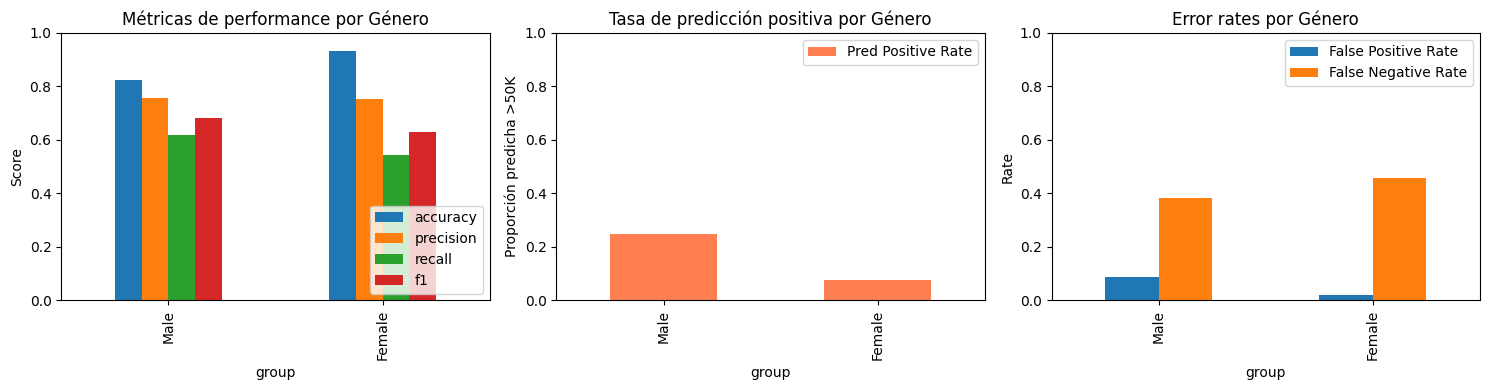


=== Métricas por Raza ===


,group,n,accuracy,precision,recall,f1,pred_positive_rate,FPR,FNR
0,White,8392,0.8515,0.7593,0.6117,0.6775,0.2054,0.0664,0.3883
1,Amer-Indian-Eskimo,97,0.9072,0.6667,0.3636,0.4706,0.0619,0.0233,0.6364
2,Black,892,0.9182,0.7470,0.5439,0.6294,0.0930,0.0270,0.4561
3,Asian-Pac-Islander,311,0.8328,0.7344,0.5732,0.6438,0.2058,0.0742,0.4268
4,Other,77,0.9610,0.6667,0.8000,0.7273,0.0779,0.0278,0.2000


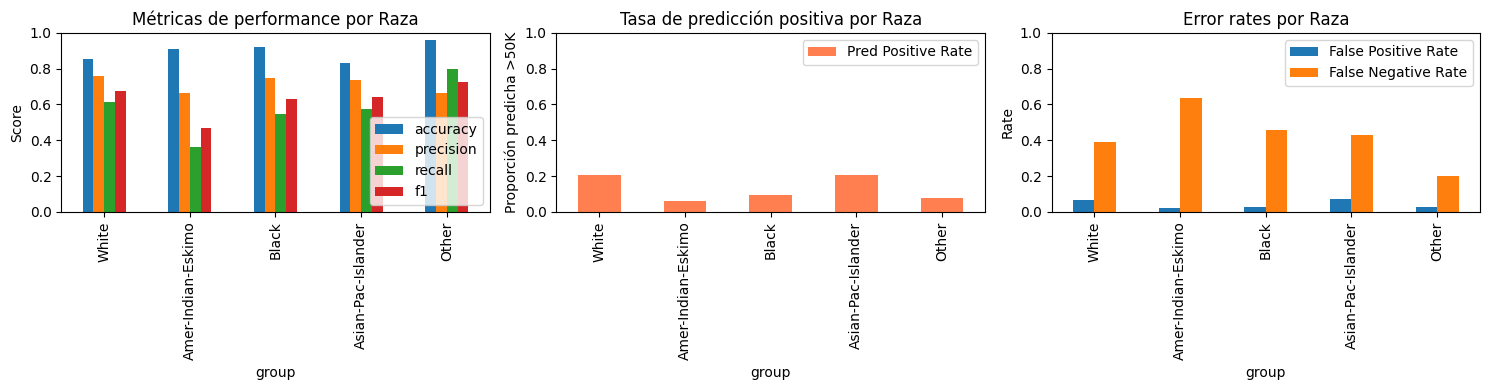

In [17]:
# Análisis de fairness por género usando el modelo calibrado (RandomForest)

# Necesitamos las variables sensibles en el test set
X_test_with_sensitive = X_test.copy()

# Función para calcular métricas por subgrupo
def fairness_metrics_by_group(y_true, y_pred, y_proba, group, group_name):
    """Calcula métricas por subgrupo para análisis de fairness"""
    results = []
    for g in group.unique():
        mask = (group == g)
        if mask.sum() == 0:
            continue
        
        y_true_g = y_true[mask]
        y_pred_g = y_pred[mask]
        y_proba_g = y_proba[mask]
        
        # Métricas básicas
        acc = accuracy_score(y_true_g, y_pred_g)
        prec = precision_score(y_true_g, y_pred_g, zero_division=0)
        rec = recall_score(y_true_g, y_pred_g, zero_division=0)
        f1 = f1_score(y_true_g, y_pred_g, zero_division=0)
        
        # Tasa de predicción positiva (demographic parity)
        positive_rate = y_pred_g.mean()
        
        # False positive rate y false negative rate
        cm = confusion_matrix(y_true_g, y_pred_g)
        tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        
        results.append({
            'group': g,
            'n': mask.sum(),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'pred_positive_rate': positive_rate,
            'FPR': fpr,
            'FNR': fnr
        })
    
    df = pd.DataFrame(results)
    print(f'\n=== Métricas por {group_name} ===')
    display(df.round(4))
    
    # Visualización
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    df.plot(kind='bar', x='group', y=['accuracy', 'precision', 'recall', 'f1'], ax=axes[0], rot=0)
    axes[0].set_title(f'Métricas de performance por {group_name}')
    axes[0].set_ylabel('Score')
    axes[0].legend(loc='lower right')
    axes[0].set_ylim([0, 1])
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)  # <--- ROTACIÓN

    df.plot(kind='bar', x='group', y='pred_positive_rate', ax=axes[1], rot=0, color='coral')
    axes[1].set_title(f'Tasa de predicción positiva por {group_name}')
    axes[1].set_ylabel('Proporción predicha >50K')
    axes[1].legend(['Pred Positive Rate'])
    axes[1].set_ylim([0, 1])
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)  # <--- ROTACIÓN

    df.plot(kind='bar', x='group', y=['FPR', 'FNR'], ax=axes[2], rot=0)
    axes[2].set_title(f'Error rates por {group_name}')
    axes[2].set_ylabel('Rate')
    axes[2].legend(['False Positive Rate', 'False Negative Rate'])
    axes[2].set_ylim([0, 1])
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=90)  # <--- ROTACIÓN

    plt.tight_layout()
    plt.show()
    
    return df

# Análisis por género
if 'sex' in X_test_with_sensitive.columns:
    gender_metrics = fairness_metrics_by_group(
        y_test.values, 
        y_pred_cal, 
        y_proba_cal, 
        X_test_with_sensitive['sex'],
        'Género'
    )

# Análisis por raza
if 'race' in X_test_with_sensitive.columns:
    race_metrics = fairness_metrics_by_group(
        y_test.values, 
        y_pred_cal, 
        y_proba_cal, 
        X_test_with_sensitive['race'],
        'Raza'
    )